## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [71]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# # save model checkpoints
# !mkdir ./ckpts

# !kaggle datasets download -d samfc10/vesuvius-zarr-files

In [72]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

# sys.path.append("/kaggle/input/resnet3d")
ROOT_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection/'
sys.path.append(ROOT_DIR)
from resnet3d import generate_model

### Config

In [73]:
DATA_DIR = ROOT_DIR
# DATA_DIR = "/kaggle/input/vesuvius-zarr-files/"
LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
NUM_WORKERS = 8
CROP_SIZE = 224
Z_START = 26
Z_DIMS = 12
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"
MODEL_DEPTH = 34
MAX_PIXEL_VALUE = 2 ** 16 - 1
RESIZE_HEIGHT = 4000
COMP_DATASET_PATH = "/home/fummicc1/codes/competitions/kaggle-ink-detection/"

### Load data

In [74]:
def resize(img):
    current_height, current_width = img.shape[:2]
    aspect_ratio = current_width / current_height
    new_height = RESIZE_HEIGHT
    new_width = int(new_height * aspect_ratio)
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

In [75]:
def calculate_mean_std(volume):
    mean_0 = np.mean(volume, axis=0)
    mean_1 = np.mean(mean_0, axis=0)
    std_0 = np.std(volume, axis=0)
    std_1 = np.std(std_0, axis=0)
    return mean_1, std_1


In [76]:
FRAGMENTS_ZARR = {
    "1" : zarr.open(f"{ROOT_DIR}train-1.zarr", mode="r"),
    "2" : zarr.open(f"{ROOT_DIR}/train-2.zarr", mode="r"),
    "3" : zarr.open(f"{ROOT_DIR}/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

In [77]:

ALL_MEAN_STD = {}
for key in ["1", "2", "3"]:
    img = np.array(FRAGMENTS_ZARR["1"]["surface_volume"])[:, :, Z_START:Z_START+Z_DIMS]

    ALL_MEAN_STD[key] = calculate_mean_std(img)

In [78]:
mean, std = ALL_MEAN_STD["1"]
mean, std

(array([16109.72300626, 16369.52307949, 16438.31554409, 16222.07887619,
        15666.64744985, 14798.68459147, 13742.24110022, 12686.91996523,
        11817.69218949, 11249.06236971, 11000.9214373 , 11017.81404872]),
 array([2441.80821036, 2483.70993246, 2488.44506847, 2445.05180237,
        2346.44990857, 2193.31216295, 2006.46319592, 1840.02783395,
        1753.62156347, 1741.95262973, 1741.04684181, 1719.55030132]))

In [79]:
list(FRAGMENTS_ZARR["1"].keys())
np.unique(np.array(FRAGMENTS_ZARR["1"]["truth"]))

array([0, 1], dtype=uint8)

In [80]:
def read_image(mode, fragment_id):
    images = []

    # idxs = range(65)
    start = Z_START
    end = Z_START + Z_DIMS
    idxs = range(start, end)

    for i in tqdm(idxs):
        image = cv2.imread(COMP_DATASET_PATH + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", -1)
        # image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)
        image = resize(image)        

        pad0 = (CROP_SIZE - image.shape[0] % CROP_SIZE)
        pad1 = (CROP_SIZE - image.shape[1] % CROP_SIZE)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

In [81]:
def fetch_fragment_crop(id: str, y1, y2, x1, x2, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        if id in ["a", "b"]:
            img = read_image("test", id)[y1:y2, x1:x2, z1:z2]
        else:
            img = read_image("train", id)[y1:y2, x1:x2, z1:z2] 
        return img.astype(np.uint16)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2]
        img = np.array(img)
        return img.astype(np.uint16)
    print("Error", key)

def fetch_fragment(id: str, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        if id in ["a", "b"]:
            img = read_image("test", id)[:, :, z1:z2]
        else:
            img = read_image("train", id)[:,:, z1:z2] 
        return img.astype(np.uint16)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key]
        img = np.array(img)
        return img.astype(np.uint8)

In [82]:
list(FRAGMENTS_ZARR["1"].array_keys())

['infrared', 'mask', 'surface_volume', 'truth']

### Visualise input

In [83]:
fragment_id = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fetch_fragment_crop("1", y, y+CROP_SIZE, x, x+CROP_SIZE, Z_START, Z_START+Z_DIMS)
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

100%|██████████| 12/12 [00:01<00:00, 11.18it/s]


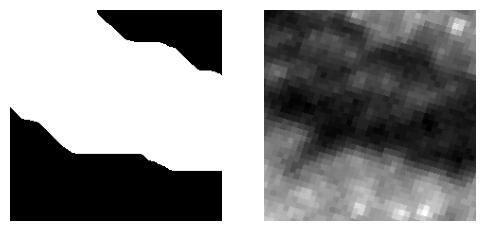

In [84]:
mask_cropped = fragment_id.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment_id.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [85]:
del fragment_id, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4807

### Dataloaders

In [86]:
class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment_id in fragments:
            H, W = FRAGMENTS_SHAPE[fragment_id]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    self.xys.append((fragment_id, x, y, W, H))
        
    def __getitem__(self, i):
        fragment_id, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-32 if x1 != 0 else 0, 32)
        y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, z1, z2)
        mask_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]        
        
        performed = A.Compose([
            A.HorizontalFlip(p=0.3), # 水平方向に反転
            A.VerticalFlip(p=0.3), # 水平方向に反転
            A.RandomRotate90(p=0.3),
            A.ShiftScaleRotate(p=0.3),
        ])(image=frag_crop, mask=mask_crop)
        frag_crop = performed["image"]
        mask_crop = performed["mask"]
        
        mean, std = ALL_MEAN_STD[fragment_id]
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).permute((2, 0, 1))
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [87]:
ALL_MEAN_STD

{'1': (array([16109.72300626, 16369.52307949, 16438.31554409, 16222.07887619,
         15666.64744985, 14798.68459147, 13742.24110022, 12686.91996523,
         11817.69218949, 11249.06236971, 11000.9214373 , 11017.81404872]),
  array([2441.80821036, 2483.70993246, 2488.44506847, 2445.05180237,
         2346.44990857, 2193.31216295, 2006.46319592, 1840.02783395,
         1753.62156347, 1741.95262973, 1741.04684181, 1719.55030132])),
 '2': (array([16109.72300626, 16369.52307949, 16438.31554409, 16222.07887619,
         15666.64744985, 14798.68459147, 13742.24110022, 12686.91996523,
         11817.69218949, 11249.06236971, 11000.9214373 , 11017.81404872]),
  array([2441.80821036, 2483.70993246, 2488.44506847, 2445.05180237,
         2346.44990857, 2193.31216295, 2006.46319592, 1840.02783395,
         1753.62156347, 1741.95262973, 1741.04684181, 1719.55030132])),
 '3': (array([16109.72300626, 16369.52307949, 16438.31554409, 16222.07887619,
         15666.64744985, 14798.68459147, 13742.241

In [88]:
class VesuviusVal(Dataset):
    def __init__(self, fragment_id):
        self.fragment_id = fragment_id
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment_id]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, z1, z2)
        
        mask_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, key="truth")

        mean, std = ALL_MEAN_STD[self.fragment_id]
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)        
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [89]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [90]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=MODEL_DEPTH):
        super().__init__()
        self.encoder = generate_model(model_depth=MODEL_DEPTH, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None] # チャネルを追加
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
   
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=SegModel()
        weight_path = "r3d18_K_200ep.pth"
        if os.path.exists(weight_path):
            self.encoder.load_pretrained_weights(torch.load(weight_path)["state_dict"])

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        # images=normalization(images)
        output = self.encoder(images)
        return output

In [91]:
model = CustomModel()
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

### Competition metric (F0.5 Score)

In [92]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [93]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.005, patience=2, min_lr=5e-5)

In [94]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [95]:
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = optimizer.param_groups[0]['lr']
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))    
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    scheduler.step(metrics=mloss_val)
    
    for threshold in np.arange(0.2, 0.65, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet{MODEL_DEPTH}_3d_seg_epoch_{epoch}.pt")

    if epoch == 30:
        break

  0%|          | 0/12 [00:00<?, ?it/s]]


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_450104/2053716892.py", line 46, in __getitem__
    frag_crop = (frag_crop - mean) / std
ValueError: operands could not be broadcast together with shapes (224,224,0) (12,) 


100%|██████████| 12/12 [00:02<00:00,  4.21it/s]
